In [23]:
# pip install lsdb
# pip install lf_tape

import pyarrow.parquet as pq
import numpy as np
import os
import lsdb
import tape

from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from tape import Ensemble, ColumnMapper
from hipscat.io.file_io import read_parquet_metadata
print(lsdb.__version__)
print(tape.__version__)

import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/ncaplar/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})
dask.config.set({"dataframe.convert-string": False})
from dask.distributed import Client

0.2.1
0.4.1


/astro/users/ncaplar/.conda/envs/tape_staticSL/lib/python3.10/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [24]:
# initialize dask client 
Client = Client(n_workers=8, threads_per_worker=1, memory_limit='40Gb')

/astro/users/ncaplar/.conda/envs/tape_staticSL/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41059 instead
  warnings.warn(


In [13]:
ztf_object_path = "/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14"
ztf_source_path = "/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source"



In [14]:
ztf_object = lsdb.read_hipscat(ztf_object_path, search_filter=ConeSearch(ra=-60, dec=20, radius_arcsec=1*1600))
#sources load takes a minute, since it creates a healpix alignment on load
ztf_source = lsdb.read_hipscat(ztf_source_path,
                               columns=['index', 'ps1_objid',
                                       'ra', 'dec', 
                                       'catflags', 
                                       'fieldID', 
                                       'mjd', 'band', 'mag', 'magerr', 'Npix'], search_filter=ConeSearch(ra=-60, dec=20, radius_arcsec=1*1600))

In [15]:
ztf_object_100 = ztf_object.query("nobs_g > 100 and nobs_r > 100")
# We do this to get the source catalog indexed by the objects hipscat index
ztf_joined_source_cat = ztf_object_100.join(
    ztf_source, left_on="ps1_objid", right_on="ps1_objid", suffixes=("_object", "")
)

/astro/users/ncaplar/.conda/envs/tape_staticSL/lib/python3.10/site-packages/lsdb/dask/join_catalog_data.py:195: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


In [16]:
colmap = ColumnMapper(
    id_col="_hipscat_index",
    time_col="mjd",
    flux_col="mag",
    err_col="magerr",  
    band_col="band",
)

ens = Ensemble(client=Client)

# We just pass in the catalog objects
ens.from_lsdb(ztf_joined_source_cat, ztf_object, column_mapper=colmap)

ens.object.compute()

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
3645663898796818432,129852995315513961,299.531509,18.211121,-999.000000,21.667700,20.771200,0,1,74,NaN,16.707520,20.641304,5,0,3238
3645663899514044416,129852995331574656,299.533154,18.211779,18.025499,17.122601,16.712799,577,1232,158,18.084419,17.038139,16.639050,5,0,3238
3645663900969467904,129852995302075776,299.530212,18.212697,20.562799,19.651300,19.229000,11,231,108,20.619924,19.703492,19.299216,5,0,3238
3645663901456007168,129852995294816101,299.529480,18.212954,21.752100,20.551500,19.889799,1,179,97,21.444788,20.630898,19.817250,5,0,3238
3645663901678305280,129852995314306059,299.531427,18.212937,17.094400,16.523100,16.258400,580,1240,159,17.086404,16.376977,16.122447,5,0,3238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647915693078216704,134423009353274611,300.935318,22.020049,22.195299,21.428101,20.957899,0,45,0,NaN,21.347121,NaN,5,0,3239
3647915693963214848,134423009380234354,300.938141,22.019936,-999.000000,22.041100,21.512699,0,4,0,NaN,21.526417,NaN,5,0,3239
3647915694005157888,134423009378754660,300.937897,22.020140,-999.000000,21.795500,20.581800,0,41,0,NaN,21.339633,NaN,5,0,3239


In [17]:
# Defining a simple function
def my_flux_average(flux_array, band_array, method="mean", band=None):
    """Read in an array of fluxes, and return the average of the fluxes by band"""
    if band != None:
        mask = [band_array == band]  # Create a band by band mask
        band_flux = flux_array[tuple(mask)]  # Mask the flux array
        if method == "mean":
            res = np.mean(band_flux)
        elif method == "median":
            res = np.median(band_flux)
    else:
        res = None
    return res

In [18]:
# Applying the function to the ensemble
res = ens.batch(my_flux_average, "mag", "band", meta=None, method="median", band="g")
res_computed = res.compute()

Using generated label, result_1, for a batch result.


2024-05-03 14:36:15,744 - distributed.worker.memory - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 9.08 GiB -- Worker memory limit: 10.50 GiB
2024-05-03 14:36:20,348 - distributed.worker.memory - WARNING - Worker is at 42% memory usage. Resuming worker. Process memory: 4.46 GiB -- Worker memory limit: 10.50 GiB
2024-05-03 14:36:21,850 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 7.64 GiB -- Worker memory limit: 10.50 GiB


In [19]:
res_computed

,result
_hipscat_index,
3646103706031620096,21.042326
3646103709890379776,16.344461
3646103711232557056,19.095978
3646103711446466560,19.706953
3646103716592877568,20.797861
...,...
3647511061923364864,20.132650
3647511065207504896,17.817490
3647511070718820352,19.901325


In [20]:
ts = ens.to_timeseries(3647494584189059072)  # provided a target object id
ts.data

ps1_objid_object  ra_object  dec_object  ps1_gMeanPSFMag_object  \
band index                                                                      
r    0      132602998825891881  299.88259    20.50113                 20.9571   
     1      132602998825891881  299.88259    20.50113                 20.9571   
     2      132602998825891881  299.88259    20.50113                 20.9571   
     3      132602998825891881  299.88259    20.50113                 20.9571   
     4      132602998825891881  299.88259    20.50113                 20.9571   
...                        ...        ...         ...                     ...   
     1634   132602998825891881  299.88259    20.50113                 20.9571   
g    322    132602998825891881  299.88259    20.50113                 20.9571   
r    1635   132602998825891881  299.88259    20.50113                 20.9571   
     1636   132602998825891881  299.88259    20.50113                 20.9571   
     1637   132602998825891881  299.88259    20.50113                 20.9571   

            ps1_rMeanPSFMag_object  ps1_iMeanPSFMag_object  nobs_g_object  \
band index                                                                  
r    0                   19.677099               19.038099            323   
     1                   19.677099               19.038099            323   
     2                   19.677099               19.038099            323   
     3                   19.677099               19.038099            323   
     4                   19.677099               19.038099            323   
...                            ...                     ...            ...   
     1634                19.677099               19.038099            323   
g    322                 19.677099               19.038099            323   
r    1635                19.677099               19.038099            323   
     1636                19.677099               19.038099            323   
     1637                19.677099               19.038099            323   

            nobs_r_object  nobs_i_object  mean_mag_g_object  ...  \
band index                                                   ...   
r    0               1638            158          21.047549  ...   
     1               1638            158          21.047549  ...   
     2               1638            158          21.047549  ...   
     3               1638            158          21.047549  ...   
     4               1638            158          21.047549  ...   
...                   ...            ...                ...  ...   
     1634            1638            158          21.047549  ...   
g    322             1638            158          21.047549  ...   
r    1635            1638            158          21.047549  ...   
     1636            1638            158          21.047549  ...   
     1637            1638            158          21.047549  ...   

                     ps1_objid         ra       dec  catflags  fieldID  \
band index                                                               
r    0      132602998825891881  299.88259  20.50113         0      592   
     1      132602998825891881  299.88259  20.50113         0      591   
     2      132602998825891881  299.88259  20.50113         0      592   
     3      132602998825891881  299.88259  20.50113         0      592   
     4      132602998825891881  299.88259  20.50113         0      592   
...                        ...        ...       ...       ...      ...   
     1634   132602998825891881  299.88259  20.50113         0      591   
g    322    132602998825891881  299.88259  20.50113         0      592   
r    1635   132602998825891881  299.88259  20.50113    -32768      592   
     1636   132602998825891881  299.88259  20.50113    -32768      591   
     1637   132602998825891881  299.88259  20.50113    -32768      591   

                    mjd  band        mag    magerr    Npix  
band index                                       

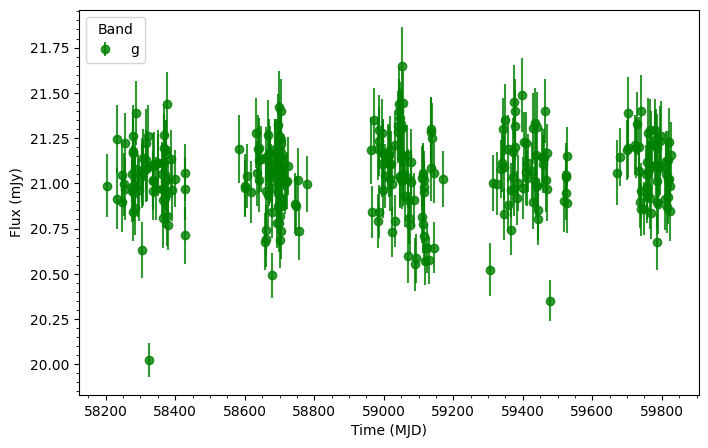

In [21]:
import matplotlib.pyplot as plt


ts_g = ts.data[ts.band == "g"]

plt.figure(figsize=(8, 5))
plt.errorbar(ts_g.mjd, ts_g.mag, ts_g.magerr, fmt="o", color="green", alpha=0.8, label="g")
plt.xlabel("Time (MJD)")
plt.ylabel("Flux (mJy)")
plt.minorticks_on()
plt.legend(title="Band", loc="upper left")